Objetive: 
- We study the problem of model selection in causal inference, specifically for the
case of conditional average treatment effect (CATE) estimation under binary treatments

Motivation:
- We are modeling $\text{CATE}: E[Y|do(X=1), Z] - E[Y|do(X=0), Z]$
- However, we don't have the counterfactual potential outcome for
any data point

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from toolz import curry

import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor

In [2]:
from pgmpy.models import BayesianNetwork

model = BayesianNetwork()
model.add_nodes_from(["treatment", "confounder", "target"])
model.add_edges_from(
    [
        ("confounder", "treatment"),
        ("confounder", "target"),
        ("treatment", "target"),
    ]
)

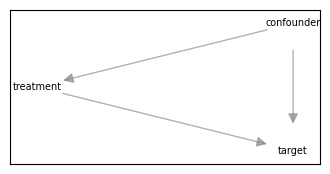

In [3]:
import networkx as nx

plt.figure(figsize=(4, 2))

nx_graph = nx.DiGraph(model.edges())
position_dicts = nx.shell_layout(nx_graph)

nx.draw_networkx_edges(
    nx_graph,
    position_dicts,
    edge_color="gray",
    node_size=1500,
    alpha=0.6,
    arrowstyle="-|>",
    arrowsize=15,
)
nx.draw_networkx_labels(nx_graph, position_dicts, font_size=7, font_color="black")
plt.show()

$$Z \sim \mathcal{N}(0, 1)$$

$$(T | Z>0) \sim \textrm{Bernoulli}(0.9)\textrm{, }T | Z\leq0 \sim \textrm{Bernoulli}(0.1)$$

$$(Y | Z=z, T=t) \sim\mathcal{N}((2 + t) * z, 1)$$

**Abrir a conta depois**

$$\textrm{CATE}_{T, Y}(Z) = Z$$

In [4]:
def generate_data(size=100, obs=True, random_state=None):
    rs = np.random.RandomState(random_state).randint(
        0, 2**32 - 1, dtype=np.int64, size=4
    )
    
    Z = np.random.RandomState(rs[0]).normal(loc=0, scale=1, size=size)
    if obs:
        T = np.random.RandomState(rs[1]).binomial(n=1, p=0.8 * (Z > 0) + 0.1)
    else:
        T = np.random.RandomState(rs[2]).binomial(n=1, p=0.5, size=size)
    Y = np.select(condlist=[T.astype(bool)], choicelist=[3 * Z], default=2 * Z) + np.random.RandomState(rs[3]).normal(size=size)
    
    df = pd.DataFrame(np.vstack([T, Z, Y]).T, columns=["treatment", "confounder", "target"])
    
    return df

In [5]:
df_obs = generate_data(size=5_000, obs=True, random_state=42)
df_rnd = generate_data(size=5_000, obs=False, random_state=42)

In [6]:
m1 = (
    smf
    .ols("target ~ treatment*confounder + confounder + treatment", data=df_obs)
    .fit()
)

m2 = (
    RandomForestRegressor(random_state=42, max_depth=5)
    .fit(df_obs[["treatment", "confounder"]], df_obs.target)
)

In [7]:
@curry
def predict_cate(df_pred, model):
    X = df_pred[["treatment", "confounder"]]
    return (
        model.predict(X.assign(treatment=1))
        - model.predict(X.assign(treatment=0))
    )

df_rnd_pred = (
    df_rnd
    .assign(cate_pred_m1=predict_cate(model=m1))
    .assign(cate_pred_m2=predict_cate(model=m2))
    .assign(cate_pred_m3=lambda df_: np.random.RandomState(42).uniform(size=df_.shape[0]))
)

df_rnd_pred.head(3)

,treatment,confounder,target,cate_pred_m1,cate_pred_m2,cate_pred_m3
0,1.0,1.250807,4.567073,1.173468,1.174298,0.374540
1,0.0,-0.170339,-0.448010,-0.155061,-0.008961,0.950714
2,0.0,-0.201175,-0.558887,-0.183887,-0.054389,0.731994


In [8]:
def elast(data):
    return (
        data.query("treatment == 1").target.mean()
        - data.query("treatment == 0").target.mean()
    )

def elast_by_band(df, col_cate_pred, bands=10):
    return (df
            .assign(**{f"{col_cate_pred}_band":lambda df_: pd.qcut(df_[col_cate_pred], q=bands)})
            .groupby(f"{col_cate_pred}_band")
            .apply(elast))

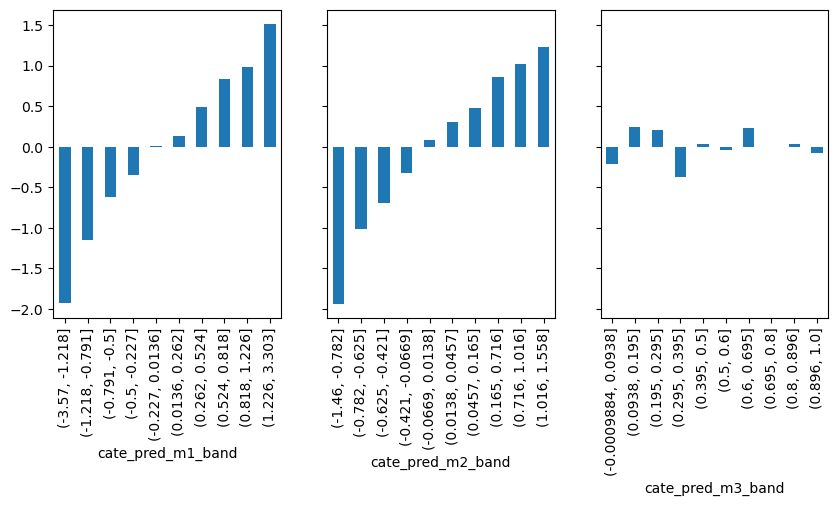

In [9]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10, 4))
for m, ax in zip(["cate_pred_m1", "cate_pred_m2", "cate_pred_m3"], axs):
    elast_by_band(df_rnd_pred, m).plot.bar(ax=ax)

References
1. [Mahajan, Divyat, et al. **Empirical Analysis of Model Selection for Heterogenous Causal Effect Estimation.** arXiv preprint arXiv:2211.01939 (2022).](https://arxiv.org/abs/2211.01939)